### Imports

In [1]:
from os.path import abspath, join
import pandas as pd
import numpy as np
from plotnine import ggplot, geom_bar, aes, scale_x_discrete, theme, element_text, labs, \
	scale_x_continuous, scale_y_continuous, geom_line, geom_boxplot, coord_flip, \
	ylim, xlim, facet_wrap, scale_fill_hue
import re
from mizani.formatters import percent_format

### Data load

In [2]:
path = "C:/Nitsan/third/JavaAnalyzer"
results_file = "analyzerResults_v2.csv"
df = pd.read_csv(abspath(join(path, results_file)))

### Data cleanup:
1. Remove type declarations:

In [3]:
df = df[~df["className"].isin(["TypeParameter","ClassOrInterfaceType"])]

2. Remove external words:

In [4]:
external_tagging_data = pd.read_csv(abspath(join(path, 'analyzerResults_words_ALL.csv')))
external_words = external_tagging_data[np.where(external_tagging_data['external'] == 1, True, False)]['word']
df= df[~df['name'].isin(external_words)]

Removed words:

In [5]:
print(external_words)

0                          T
1                     String
3                          R
4                     Object
8                  Throwable
9             requireNonNull
19               IOException
20                   Integer
29                     Class
30                      List
37                       com
61                      java
84                         K
88          serialVersionUID
89                         V
115          AtomicReference
116                     Long
118                 toString
123                      Map
129                     Type
170     InterruptedException
194               Collection
202                 Iterable
211              InputStream
220                ArrayList
222                     Math
241                      Set
275                   Arrays
279             OutputStream
283                  Boolean
308               AtomicLong
327              Collections
336     NullPointerException
338            AtomicInteger
430         Ru

### Dataframe preview:

In [6]:
print(df.sample(frac=1).head())

              project          name           className         role  length
172573        Jenkins             b  VariableDeclarator  DECLARATION       1
361859     Playwright     mainFrame            NameExpr    REFERENCE       9
389713  Signal-Server        PARSER            NameExpr    REFERENCE       6
433862        XXL-Job             e            NameExpr    REFERENCE       1
162232        Jenkins  isEnabledFor   MethodDeclaration  DECLARATION      12


### Histogram of 50 most common words in all projects together:

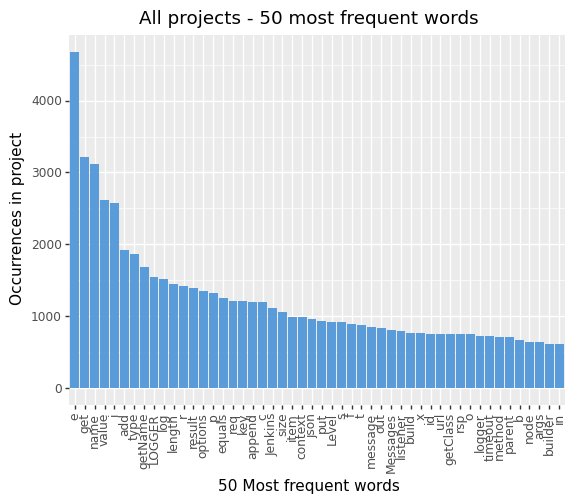

<ggplot: (84882461549)>


In [27]:
fill='#5a9cd9'
n=50
hist_name_external_all = df.groupby(["name"]).size().reset_index(name="count")
hist_name_external_all = hist_name_external_all.nlargest(n, "count")

print(
	ggplot(hist_name_external_all)
	+ labs(x=str(n) + " Most frequent words",
		   y="Occurrences in project",
		   title="All projects - " + str(n) + " most frequent words")
	+ scale_x_discrete(limits=hist_name_external_all['name'].tolist())
	+ geom_bar(aes(x='name', y='count'), fill=fill, stat='identity')
	+ theme(axis_text_x=element_text(rotation=90))
)

### Zipf's Law - Words rank / frequency in log scale:

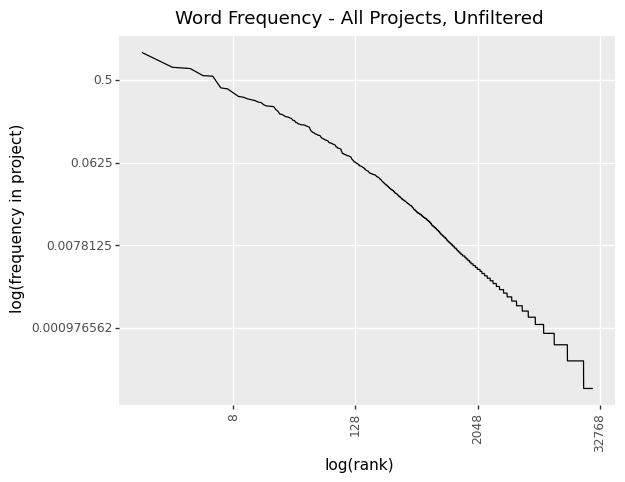

<ggplot: (84881816269)>


In [8]:
freq_name_external_all = df.groupby(["name"]).size() \
	.reset_index(name="count") \
	.sort_values("count", ascending=False)
most_frequent_word_occurrences = int(freq_name_external_all[:1]['count'])

freq_name_external_all['frequency'] = freq_name_external_all['count'] / most_frequent_word_occurrences
data_length = freq_name_external_all.shape[0]
freq_name_external_all['rank'] = np.linspace(1, data_length, data_length)

print(ggplot(freq_name_external_all)
	  + labs(x="log(rank)",
			 y="log(frequency in project)",
			 title="Word Frequency - All Projects, Unfiltered")
	  + scale_x_continuous(trans='log2') + scale_y_continuous(trans='log2')
	  + geom_line(aes(x='rank', y='frequency'), stat='identity')
	  + theme(axis_text_x=element_text(rotation=90))
	  )


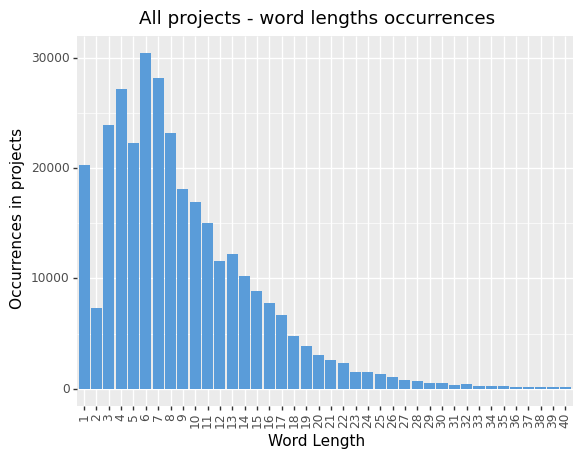

<ggplot: (84881842565)>


In [28]:
n=40
hist_length_df = df.groupby(["length"]).size().reset_index(name="count")
hist_length_df = hist_length_df.nsmallest(n, "length")

print(
	ggplot(hist_length_df)
	+ labs(x="Word Length",
		   y="Occurrences in projects",
		   title="All projects - word lengths occurrences")
	+ scale_x_discrete(limits=range(1, 41))
	+ geom_bar(aes(x='length', y='count'), fill=fill, stat='identity')
	+ theme(axis_text_x=element_text(rotation=90))
)

In [10]:
freq_name_length_project = df.groupby(["name", "length", "project"]).size() \
    .reset_index(name="count") \
    .sort_values("count", ascending=False)

freq_name_length_project = freq_name_length_project.merge(freq_name_external_all[["rank", "name"]], on="name", how="left")
data_length = freq_name_length_project.shape[0]
freq_name_length_project['project_rank'] = np.linspace(1, data_length, data_length)

target_bin = int(np.ceil(np.math.log(freq_name_length_project.shape[0])))
freq_name_length_project["rank_bin"] = pd.cut(freq_name_length_project["rank"], bins=[0]+list(np.logspace(0, target_bin, target_bin+1)))
freq_name_length_project["project_rank_bin"] = pd.cut\
	(freq_name_length_project["project_rank"],
														   bins=[0]+list(np.logspace(0, target_bin, target_bin+1)))

print(freq_name_length_project.head())


     name  length  project  count  rank  project_rank       rank_bin  \
0       e       1  Jenkins   2489   1.0           1.0     (0.0, 1.0]   
1    name       4  Jenkins   1611   3.0           2.0    (1.0, 10.0]   
2     get       3  Jenkins   1533   2.0           3.0    (1.0, 10.0]   
3  LOGGER       6  Jenkins   1530   9.0           4.0    (1.0, 10.0]   
4       r       1  Jenkins   1336  12.0           5.0  (10.0, 100.0]   

  project_rank_bin  
0       (0.0, 1.0]  
1      (1.0, 10.0]  
2      (1.0, 10.0]  
3      (1.0, 10.0]  
4      (1.0, 10.0]  


### Global ranking
Same words in different projects get the same rank, by their global count total

c:\users\alich\appdata\local\programs\python\python38\lib\site-packages\plotnine\layer.py:360: PlotnineWarning: stat_boxplot : Removed 1486 rows containing non-finite values.
  data = self.stat.compute_layer(data, params, layout)
c:\users\alich\appdata\local\programs\python\python38\lib\site-packages\plotnine\layer.py:360: PlotnineWarning: stat_boxplot : Removed 1486 rows containing non-finite values.
  data = self.stat.compute_layer(data, params, layout)


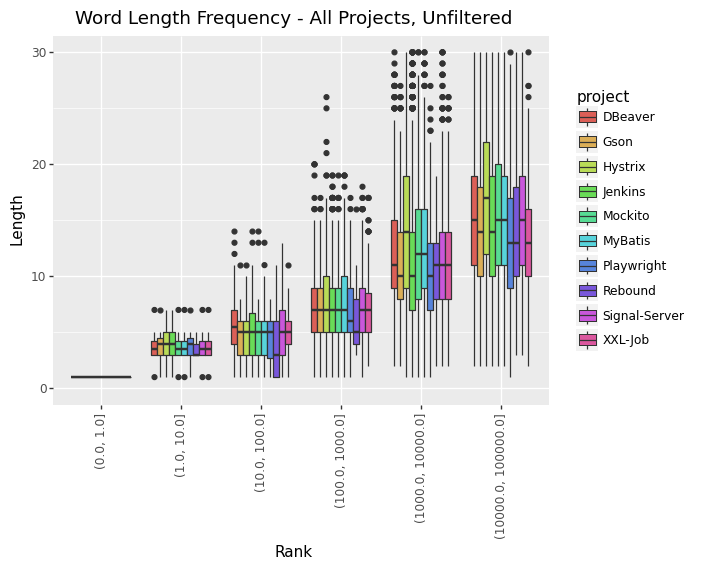

<ggplot: (84829215751)>
<ggplot: (84882373524)>


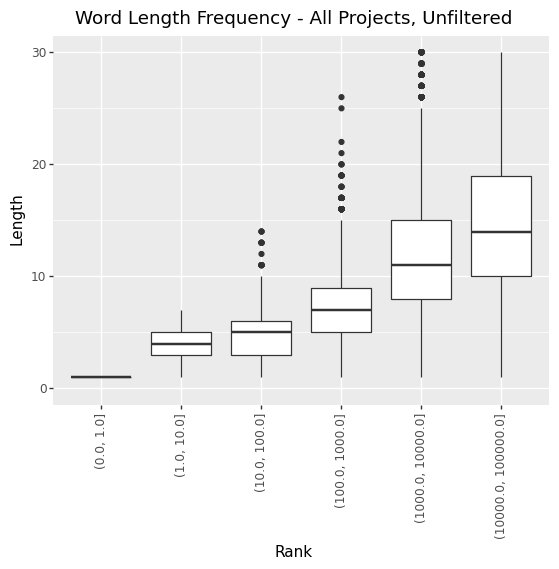

In [11]:
print(ggplot(freq_name_length_project)
      + labs(y="Length",
             x="Rank",
             title="Word Length Frequency - All Projects, Unfiltered")
      + geom_boxplot(aes(x='rank_bin', y='length', fill="project"), position="dodge")
      + ylim(0, 30)
      + theme(axis_text_x=element_text(rotation=90))
      )

print(ggplot(freq_name_length_project)
      + labs(y="Length",
             x="Rank",
             title="Word Length Frequency - All Projects, Unfiltered")
      + geom_boxplot(aes(x='rank_bin', y='length'))
      + ylim(0, 30)
      + theme(axis_text_x=element_text(rotation=90))
      )


### Project separated ranking
Same words in different projects get different ranking and are treated as different words

c:\users\alich\appdata\local\programs\python\python38\lib\site-packages\plotnine\layer.py:360: PlotnineWarning: stat_boxplot : Removed 1486 rows containing non-finite values.
  data = self.stat.compute_layer(data, params, layout)
c:\users\alich\appdata\local\programs\python\python38\lib\site-packages\plotnine\layer.py:360: PlotnineWarning: stat_boxplot : Removed 1486 rows containing non-finite values.
  data = self.stat.compute_layer(data, params, layout)


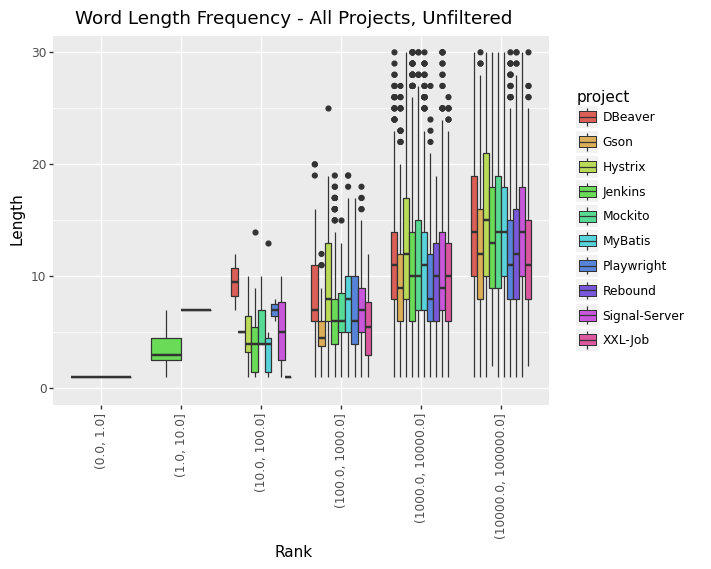

<ggplot: (84882232423)>
<ggplot: (84882245608)>


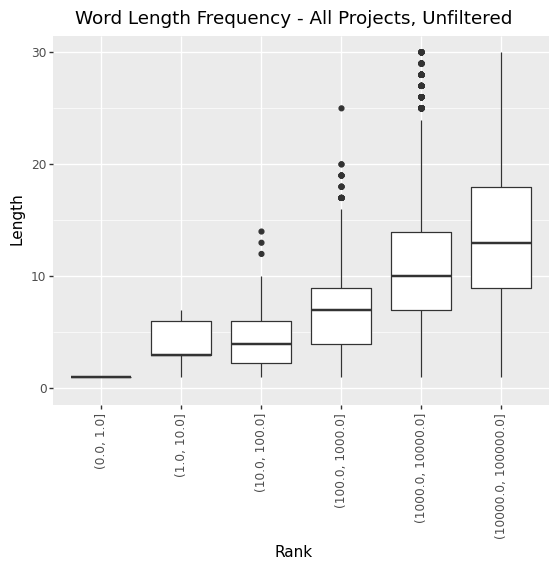

In [12]:
print(ggplot(freq_name_length_project)
      + labs(y="Length",
             x="Rank",
             title="Word Length Frequency - All Projects, Unfiltered")
      + geom_boxplot(aes(x='project_rank_bin', y='length', fill="project"), position="dodge")
      + ylim(0, 30)
      + theme(axis_text_x=element_text(rotation=90))
      )

print(ggplot(freq_name_length_project)
      + labs(y="Length",
             x="Rank",
             title="Word Length Frequency - All Projects, Unfiltered")
      + geom_boxplot(aes(x='project_rank_bin', y='length'))
      + ylim(0, 30)
      + theme(axis_text_x=element_text(rotation=90))
      )

c:\users\alich\appdata\local\programs\python\python38\lib\site-packages\plotnine\layer.py:360: PlotnineWarning: stat_boxplot : Removed 1486 rows containing non-finite values.
  data = self.stat.compute_layer(data, params, layout)


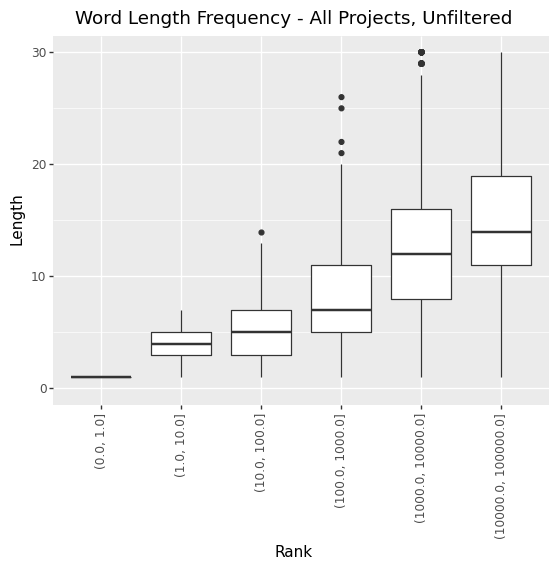

<ggplot: (84882534587)>


In [13]:
freq_name_length = df.groupby(["name", "length"]) \
    .size() \
    .reset_index(name="count") \
    .sort_values("count", ascending=False)
data_length = freq_name_length.shape[0]
freq_name_length['rank'] = np.linspace(1, data_length, data_length)

target_bin = int(np.ceil(np.math.log(freq_name_length.shape[0])))
freq_name_length["rank_bin"] = pd.cut(freq_name_length["rank"], bins=[0]+list(np.logspace(0, target_bin, target_bin+1)))

print(ggplot(freq_name_length)
      + labs(y="Length",
             x="Rank",
             title="Word Length Frequency - All Projects, Unfiltered")
      + geom_boxplot(aes(x='rank_bin', y='length'))
      + ylim(0, 30)
      + theme(axis_text_x=element_text(rotation=90))
      )

# Comparison to English / German corpora


### Setup Brown corpus data:

In [14]:
brown_data_file = "brown.csv"
brown_df = pd.read_csv(abspath(join(path, brown_data_file)))

brown_word_freq = brown_df.groupby(["Item"]).Frequency\
	.sum()\
	.reset_index()\
	.sort_values("Frequency", ascending=False)
brown_most_freq_word_occurrences = int(brown_word_freq[:1]['Frequency'])

brown_word_freq['Frequency'] = brown_word_freq['Frequency'] / brown_most_freq_word_occurrences
brown_data_length = brown_word_freq.shape[0]
brown_word_freq['rank'] = np.linspace(1, brown_data_length, brown_data_length)

### Zipf's law - Brown corpus:

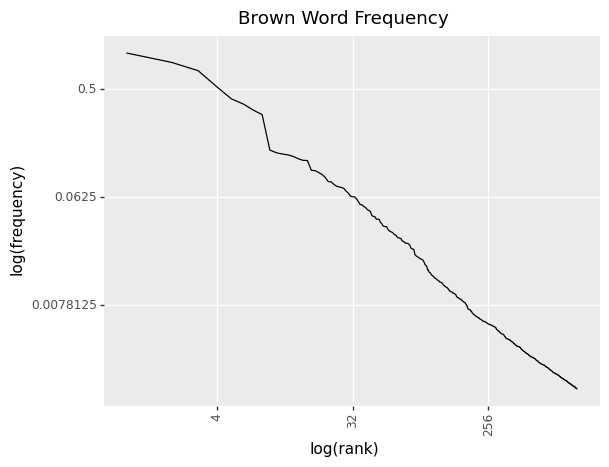

<ggplot: (84882473593)>
<ggplot: (84882447773)>


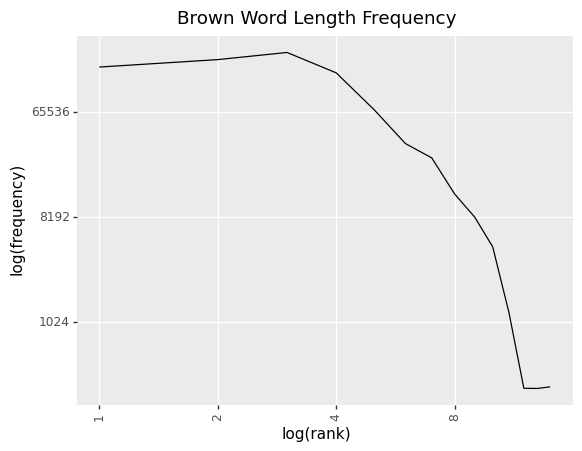

In [15]:
print(ggplot(brown_word_freq)
	  + labs(x="log(rank)",
			 y="log(frequency)",
			 title="Brown Word Frequency")
	  + scale_x_continuous(trans='log2') + scale_y_continuous(trans='log2')
	  + geom_line(aes(x='rank', y='Frequency'), stat='identity')
	  + theme(axis_text_x=element_text(rotation=90))
	  )



brown_df["length"] = brown_df['Item'].str.len()
brown_length_freq = brown_df.groupby(["length"]).Frequency.sum().reset_index()
brown_data_length = brown_length_freq.shape[0]
brown_length_freq['rank'] = np.linspace(1, brown_data_length, brown_data_length)

brown_target_bin = int(np.ceil(np.math.log2(brown_length_freq.shape[0])))
brown_length_freq["rank_bin"] = pd.cut(brown_length_freq["rank"], bins=[0]+list(np.logspace(0, brown_target_bin, brown_target_bin+1, base=2)))



print(ggplot(brown_length_freq)
      + labs(x="log(rank)",
             y="log(frequency)",
             title="Brown Word Length Frequency")
      + scale_x_continuous(trans='log2') + scale_y_continuous(trans='log2')
      + geom_line(aes(x='rank', y='Frequency'), stat='identity')
      + theme(axis_text_x=element_text(rotation=90))
      )


### Setup Coca corpus data:

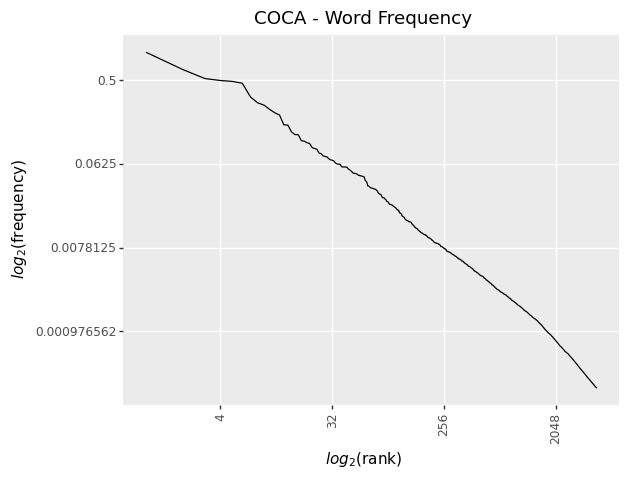

<ggplot: (84882534931)>


In [16]:
coca_data_file = "coca.csv"
coca_df = pd.read_csv(abspath(join(path, coca_data_file)))
coca_df["length"] = coca_df['word'].str.len()

coca_word_freq = coca_df.groupby(["word"])["count"].sum()\
	.reset_index()\
	.sort_values("count", ascending=False)
gwt_most_freq_word_occurrences = int(coca_word_freq[:1]['count'])

coca_word_freq['count'] = coca_word_freq['count'] / gwt_most_freq_word_occurrences
gwt_data_length = coca_word_freq.shape[0]
coca_word_freq['rank'] = np.linspace(1, gwt_data_length, gwt_data_length)

print(ggplot(coca_word_freq)
	  + labs(x="$log_2$(rank)",
			 y="$log_2$(frequency)",
			 title="COCA - Word Frequency")
	  + scale_x_continuous(trans='log2') + scale_y_continuous(trans='log2')
	  + geom_line(aes(x='rank', y='count'), stat='identity')
	  + theme(axis_text_x=element_text(rotation=90))
	  )



### Define case splitting function - split by camelCase / PascalCase / snake_case:

In [17]:
def camel_case_split_and_count(inpt):
	if inpt is None:
		return 0
	return len(re.findall(r'_?[A-Za-z_](?:[a-z0-9]+|[_A-Z]*(?=[_A-Z]|$))', str(inpt)))

### Setup data for word splitting graphs:

In [18]:
wordCount_freq = df.groupby("name").size().reset_index(name="count").sort_values("count", ascending=False)
wordCount_freq["wordCount"] = wordCount_freq["name"].apply(camel_case_split_and_count).astype('category')
most_frequent_word_occurrences = int(wordCount_freq[:1]['count'])
data_length = wordCount_freq.shape[0]
wordCount_freq['frequency'] = wordCount_freq['count'] / most_frequent_word_occurrences
wordCount_freq['rank'] = np.linspace(1, data_length, data_length)

target_bin = int(np.ceil(np.math.log(wordCount_freq.shape[0])))
wordCount_freq["rank_bin"] = pd.cut(wordCount_freq["rank"],
									bins=[0] + list(np.logspace(0, target_bin, target_bin + 1)))

### Identifiers frequency, with word count breakdown:

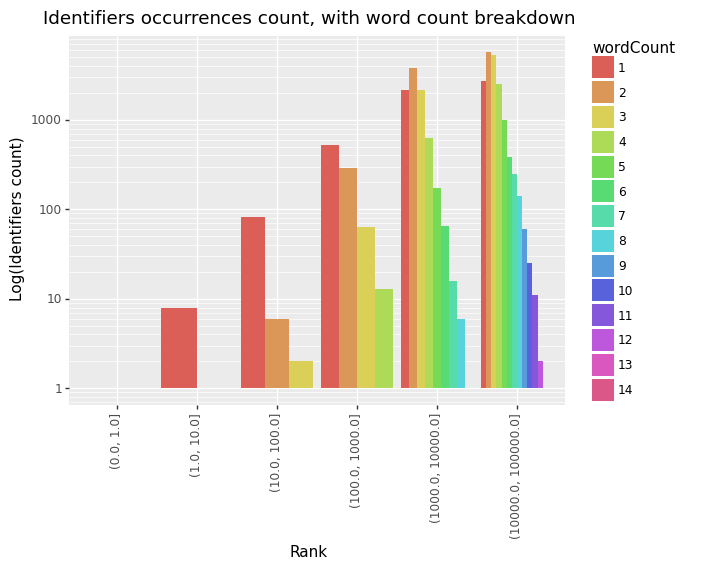

<ggplot: (84882862589)>


In [19]:
print(
	ggplot(wordCount_freq)
	+ labs(x="Rank",
		   y="Log(Identifiers count)",
		   title="Identifiers occurrences count, with word count breakdown")
	+ geom_bar(aes(x='rank_bin', fill="wordCount"), position="dodge")
	+ scale_y_continuous(trans='log10')
	+ theme(axis_text_x=element_text(rotation=90))
)

In [20]:
wordCount_length_project_freq = df.groupby(["name", "length", "project"]).size()\
	.reset_index()\
	.sort_values("length", ascending=False)
wordCount_length_project_freq["wordCount"] = wordCount_length_project_freq["name"].apply(camel_case_split_and_count).astype('category')

### Identifiers lengths frequency, with word count breakdown - per project:

c:\users\alich\appdata\local\programs\python\python38\lib\site-packages\plotnine\layer.py:360: PlotnineWarning: stat_count : Removed 889 rows containing non-finite values.
  data = self.stat.compute_layer(data, params, layout)
c:\users\alich\appdata\local\programs\python\python38\lib\site-packages\plotnine\positions\position.py:204: PlotnineWarning: position_stack requires non-overlapping x intervals
  warn(msg.format(cls.__name__), PlotnineWarning)
c:\users\alich\appdata\local\programs\python\python38\lib\site-packages\plotnine\layer.py:452: PlotnineWarning: geom_bar : Removed 25 rows containing missing values.
  self.data = self.geom.handle_na(self.data)


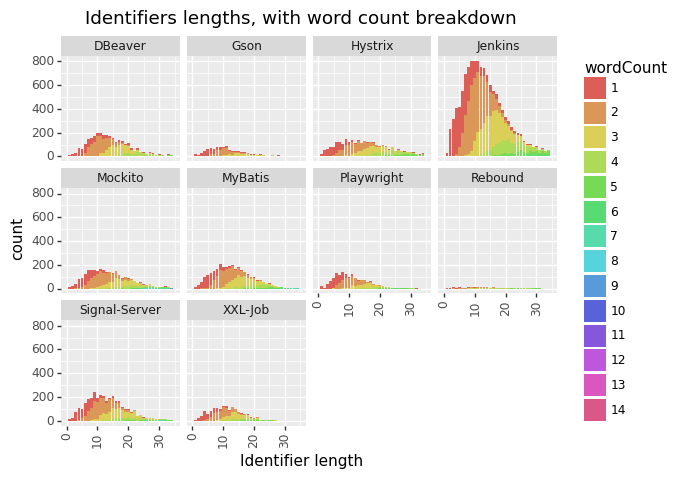

<ggplot: (84882484821)>


In [21]:
print(
	ggplot(wordCount_length_project_freq)
	+ labs(x="Identifier length",
		   y="count",
		   title="Identifiers lengths, with word count breakdown")
	+ geom_bar(aes(x='length', fill="wordCount"))
  	+ xlim(0, 35)
	+ facet_wrap("project")
	+ theme(axis_text_x=element_text(rotation=90))
)


In [22]:
wordCount_length_freq_without_jenkins = df[df["project"] != "Jenkins"].groupby(["name", "length"])\
	.size()\
	.reset_index()\
	.sort_values("length", ascending=False)
wordCount_length_freq = df.groupby(["name", "length"])\
	.size()\
	.reset_index()\
	.sort_values("length", ascending=False)
wordCount_length_freq["wordCount"] = wordCount_length_freq["name"].apply(camel_case_split_and_count).astype('category')
wordCount_length_freq_without_jenkins["wordCount"] = wordCount_length_freq_without_jenkins["name"].apply(camel_case_split_and_count).astype('category')

### Identifiers lengths frequency with word count breakdown for all project combined:

c:\users\alich\appdata\local\programs\python\python38\lib\site-packages\plotnine\layer.py:360: PlotnineWarning: stat_count : Removed 589 rows containing non-finite values.
  data = self.stat.compute_layer(data, params, layout)
c:\users\alich\appdata\local\programs\python\python38\lib\site-packages\plotnine\layer.py:452: PlotnineWarning: geom_bar : Removed 6 rows containing missing values.
  self.data = self.geom.handle_na(self.data)
c:\users\alich\appdata\local\programs\python\python38\lib\site-packages\plotnine\layer.py:360: PlotnineWarning: stat_count : Removed 889 rows containing non-finite values.
  data = self.stat.compute_layer(data, params, layout)
c:\users\alich\appdata\local\programs\python\python38\lib\site-packages\plotnine\layer.py:452: PlotnineWarning: geom_bar : Removed 7 rows containing missing values.
  self.data = self.geom.handle_na(self.data)


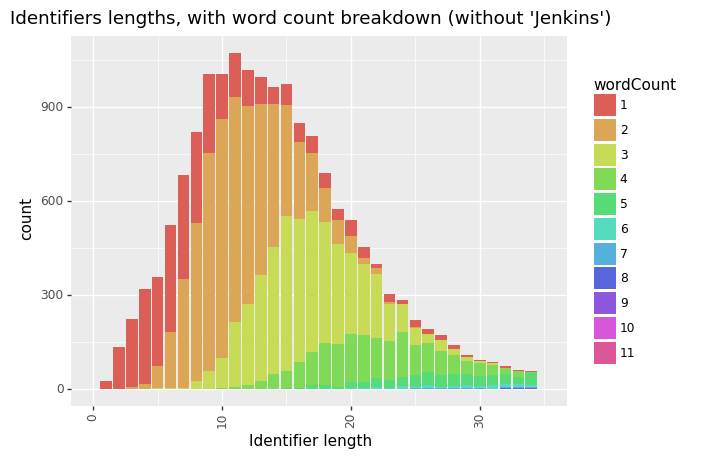

<ggplot: (84882606544)>
<ggplot: (84882260077)>


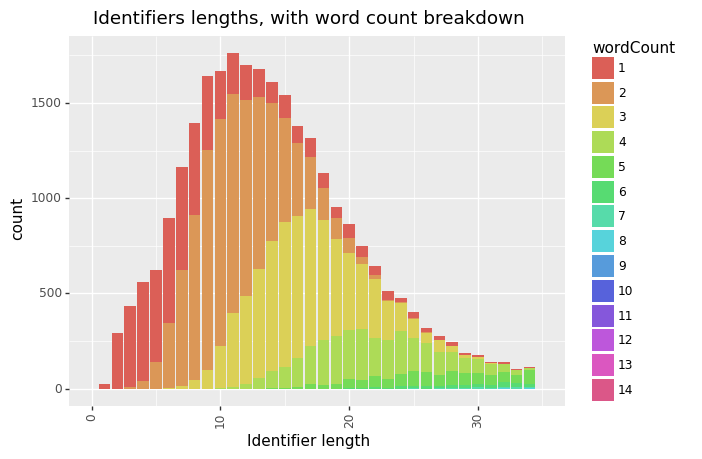

In [23]:
print(
	ggplot(wordCount_length_freq_without_jenkins)
	+ labs(x="Identifier length",
		   y="count",
		   title="Identifiers lengths, with word count breakdown (without 'Jenkins')")
	+ geom_bar(aes(x='length', fill="wordCount"))
  	+ xlim(0, 35)
	+ theme(axis_text_x=element_text(rotation=90))
)

print(
	ggplot(wordCount_length_freq)
	+ labs(x="Identifier length",
		   y="count",
		   title="Identifiers lengths, with word count breakdown")
	+ geom_bar(aes(x='length', fill="wordCount"))
  	+ xlim(0, 35)
	+ theme(axis_text_x=element_text(rotation=90))
)

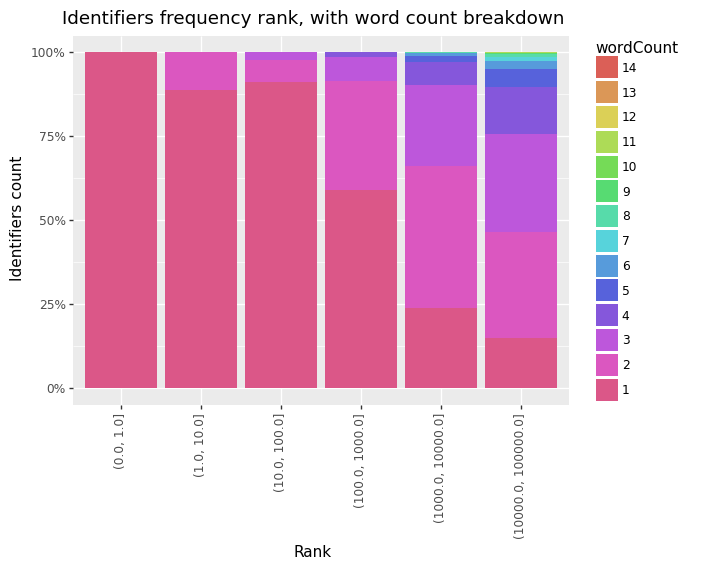

<ggplot: (84882656726)>
<ggplot: (84882413894)>


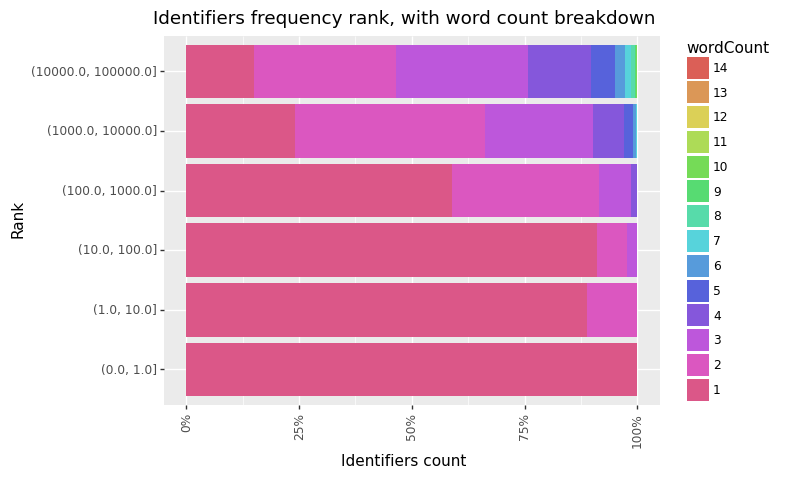

In [24]:
wordCount_freq = df.groupby("name").size().reset_index(name="count").sort_values("count", ascending=False)
wordCount_freq["wordCount"] = wordCount_freq["name"].apply(camel_case_split_and_count).astype('category')
wordCount_freq['wordCount'] = pd.Categorical(wordCount_freq["wordCount"],
                                             categories=list(range(14, 0, -1)),
                                             ordered=True)

most_frequent_word_occurrences = int(wordCount_freq[:1]['count'])
data_length = wordCount_freq.shape[0]
wordCount_freq['frequency'] = wordCount_freq['count'] / most_frequent_word_occurrences
wordCount_freq['rank'] = np.linspace(1, data_length, data_length)

target_bin = int(np.ceil(np.math.log(wordCount_freq.shape[0])))
wordCount_freq["rank_bin"] = pd.cut(wordCount_freq["rank"],
									bins=[0] + list(np.logspace(0, target_bin, target_bin + 1)))

# print(
# 	ggplot(wordCount_freq)
# 	+ labs(x="Rank",
# 		   y="log(Identifiers count)",
# 		   title="Identifiers frequency rank, with word count breakdown")
# 	+ geom_bar(aes(x='rank_bin', fill="wordCount"), position="dodge")
# 	+ scale_y_continuous(trans='log10')
# 	+ theme(axis_text_x=element_text(rotation=90))
# )
#
#
# print(
# 	ggplot(wordCount_freq)
# 	+ labs(x="Rank",
# 		   y="log(Identifiers count)",
# 		   title="Identifiers frequency rank, with word count breakdown")
# 	+ geom_bar(aes(x='rank_bin', fill="wordCount"), position="fill")
# 	+ scale_y_continuous(trans='log10', labels=percent_format())
# 	+ theme(axis_text_x=element_text(rotation=90))
# )
#

print(
	ggplot(wordCount_freq)
	+ labs(x="Rank",
		   y="Identifiers count",
		   title="Identifiers frequency rank, with word count breakdown")
	+ geom_bar(aes(x='rank_bin', fill="wordCount"), position="fill")
	+ scale_y_continuous(labels=percent_format())
	+ scale_fill_hue()
	+ theme(axis_text_x=element_text(rotation=90))
)

print(
	ggplot(wordCount_freq)
	+ labs(x="Rank",
		   y="Identifiers count",
		   title="Identifiers frequency rank, with word count breakdown")
	+ geom_bar(aes(x='rank_bin', fill="wordCount"), position="fill")
	+ scale_y_continuous(labels=percent_format())
	+ theme(axis_text_x=element_text(rotation=90))
	+ scale_fill_hue()
	+ coord_flip()
)